In [361]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from collections import Counter
import nltk
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns

class Problem():
    def __init__(self, data):
        self.problem = data['problem']
        try: self.level = re.search(r'\d', data['level'])[0]
        except: self.level = None
        self.type =  data['type']
        self.solution = data['solution']
        self.problem_numbers = self.count_numbers(self.problem)
        self.solution_numbers = self.count_numbers(self.solution)

    def count_numbers(self,s):
        return len(re.findall(r'\d+', s))
    
    def __str__(self):
        return str({"problem": self.problem, "level": self.level, "type": self.type, "solution": self.solution})
    
    def __repr__(self):
        return self.__str__()

# Exploring the MATH Dataset

## Introduction
Have you ever looked at a Math problem and had no clue on how to solve it? It might be possible that if different types of problems can be clustered into different groups of similar problems, then that might provide some insight on if the problems can be solved in similar ways. Also, when it comes to numbers and math problems, Natural Language Processing (NLP) tools such as Large Language Models (LLMs) can struggle. So, it is interesting to look at a collection of data that might be difficult for LLMs to solve to see if any other insight can be gain from trends within the data. 

The MATH dataset contains 12,500 problems from different U.S. math competitions such as AMC, AIME, Putnam, and more. Each problem in the dataset contains information including the problem's text, the solution, the subject of the problem, and the difficulty of the problem. The possible subjects for the problems include Prealgebra, Algebra, Number Theory, Counting and Probability, Geometry, Intermediate Algebra,
and Precalculus. 

Most of our code is hidden in this report for readability, but to get an idea of our dataset, here is a peak the code for loading the dataset:

In [362]:
class Problem():
    def __init__(self, data):
        self.problem = data['problem']
        try: self.level = re.search(r'\d', data['level'])[0]
        except: self.level = None
        self.type =  data['type']
        self.solution = data['solution']
        self.problem_numbers = self.count_numbers(self.problem)
        self.solution_numbers = self.count_numbers(self.solution)

    def count_numbers(self,s):
        return len(re.findall(r'\d+', s))
    
    def __str__(self):
        return str({"problem": self.problem, "level": self.level, "type": self.type, "solution": self.solution})
    
    def __repr__(self):
        return self.__str__()

Here is an example problem:

In [387]:
path_to_train = "../MATH/train"

problems = []

for root, dirs, files in os.walk(path_to_train):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith(".json"):
            with open(file_path, "r") as f:
                problems.append(Problem(json.load(f)))

path_to_test = "../MATH/test/"

test_problems = []

for root, dirs, files in os.walk(path_to_test):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith(".json"):
            with open(file_path, "r") as f:
                test_problems.append(Problem(json.load(f)))

test_categories = [prob.type for prob in test_problems]
test_difficulty = [prob.level for prob in test_problems]
test_problem_text = [' '.join(prob.problem.lower().replace(".", "").replace("?", "").replace(",", "").split()) for prob in test_problems]

levels = [problem.level for problem in problems]
levels = [level for level in levels if level is not None]
level_counts = {level: levels.count(level) for level in set(levels)}
sorted_level_counts = dict(sorted(level_counts.items(), key=lambda x: x[1]))

types = [problem.type for problem in problems]
type_counts = {type: types.count(type) for type in types}
sorted_type_counts = dict(sorted(type_counts.items(), key=lambda x: x[1]))


In [394]:
example = problems[0]
print(example.problem)
print(example.solution)
print(example.level)
print(example.type)

A board game spinner is divided into three parts labeled $A$, $B$  and $C$. The probability of the spinner landing on $A$ is $\frac{1}{3}$ and the probability of the spinner landing on $B$ is $\frac{5}{12}$.  What is the probability of the spinner landing on $C$? Express your answer as a common fraction.
The spinner is guaranteed to land on exactly one of the three regions, so we know that the sum of the probabilities of it landing in each region will be 1. If we let the probability of it landing in region $C$ be $x$, we then have the equation $1 = \frac{5}{12}+\frac{1}{3}+x$, from which we have $x=\boxed{\frac{1}{4}}$.
1
Counting & Probability


And here is a distribution of subjects among all the problems:

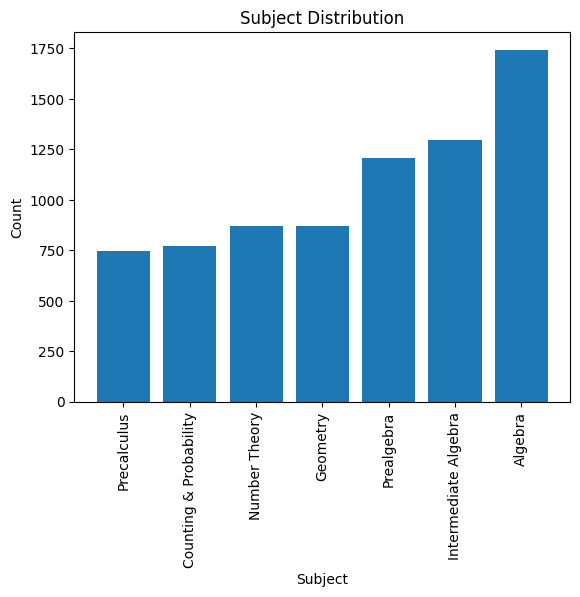

In [364]:
plt.bar(sorted_type_counts.keys(), sorted_type_counts.values())
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Subject Distribution')
plt.show()

The difficulty of the problems range from 1 to 5. This difficulty rating is given by Art of Problem Solving (AoPS). AoPS takes into account that some subjects may be more difficult than others, so the difficulty is in the scope of the subject. Here is a distribution of difficulty among all the problems:

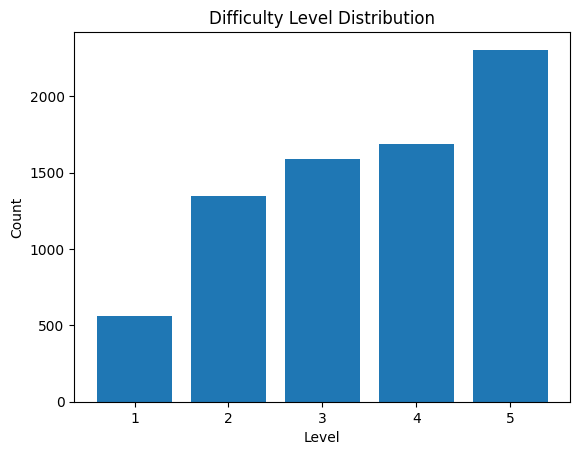

In [365]:
plt.bar(sorted_level_counts.keys(), sorted_level_counts.values())
plt.xlabel('Level')
plt.ylabel('Count')
plt.title('Difficulty Level Distribution')
plt.show()

Here are the distributions of difficulty for each subject:

In [366]:

subjects = list(set(types))

level_counts_by_subject = {subject: [] for subject in subjects}

for subject in subjects:
    subject_levels = [problem.level for problem in problems if problem.type == subject]
    subject_level_counts = Counter(subject_levels)
    for level in sorted_level_counts.keys():
        level_counts_by_subject[subject].append(subject_level_counts[level])

level_counts_array = np.array(list(level_counts_by_subject.values()))

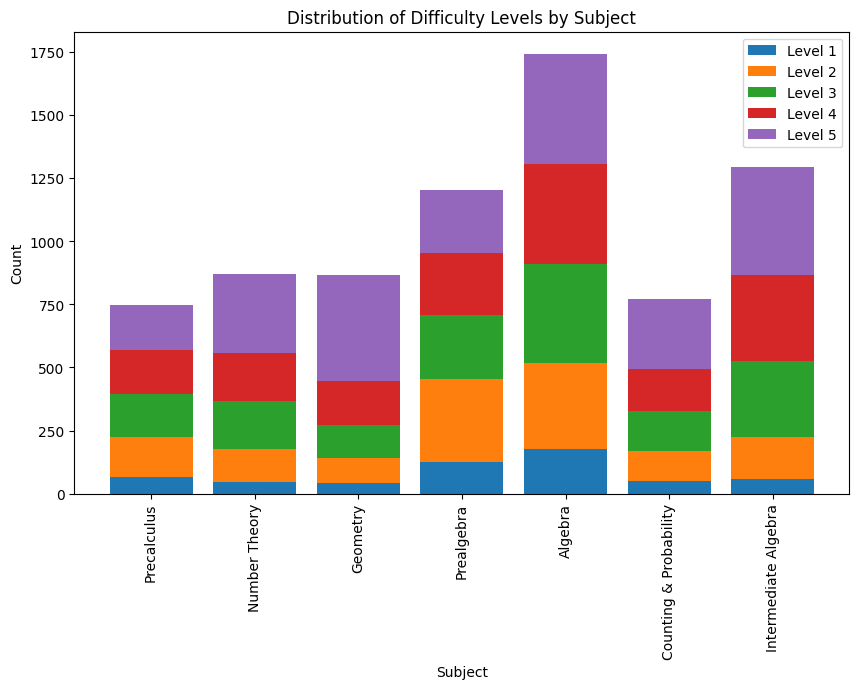

In [367]:
plt.figure(figsize=(10, 6))
plt.bar(subjects, level_counts_array[:, 0], label='Level 1')
plt.bar(subjects, level_counts_array[:, 1], bottom=level_counts_array[:, 0], label='Level 2')
plt.bar(subjects, level_counts_array[:, 2], bottom=level_counts_array[:, 0] + level_counts_array[:, 1], label='Level 3')
plt.bar(subjects, level_counts_array[:, 3], bottom=level_counts_array[:, 0] + level_counts_array[:, 1] + level_counts_array[:, 2], label='Level 4')
plt.bar(subjects, level_counts_array[:, 4], bottom=level_counts_array[:, 0] + level_counts_array[:, 1] + level_counts_array[:, 2] + level_counts_array[:, 3], label='Level 5')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.title('Distribution of Difficulty Levels by Subject')
plt.legend()
plt.xticks(rotation=90)
plt.show()

We can see that overall among all the problems and with each subject, the distribution is not a normal distribution. So, this must be taking into account when doing later analysis of the future outcomes.

To analyze the trends, we want to see if the subject of the problem or the difficulty of the problem can be predicted based on the content of the problem statement.

## Methods

Some content trends we planned to initially explore are the predictability of the subject or difficulty using content such as the magnitude of numbers, the amount of numbers, or the words in the problem statement. 

### Exploring Numbers

For content like the magnitude of numbers and the amount of numbers, we plotted a distribution in order to see if there are clear delinations between the subjects and the difficulties of problems. 

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


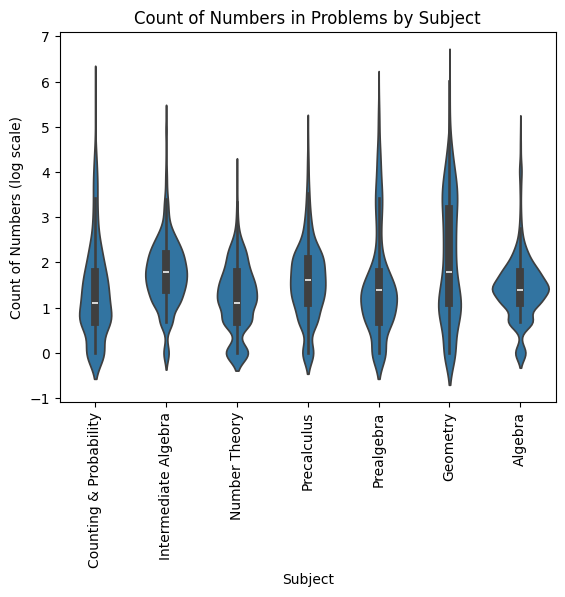

In [368]:
types = [problem.type for problem in problems]
numbers = [problem.problem_numbers for problem in problems]
df = pd.DataFrame({'type': types, 'numbers': numbers})

df['numbers'] = np.log(df['numbers'])

sns.violinplot(x='type', y='numbers', data=df)
plt.xticks(rotation=90)
plt.xlabel('Subject')
plt.ylabel('Count of Numbers (log scale)')
plt.title('Count of Numbers in Problems by Subject')
plt.show()

Unfortunately, there wasn't really anything meaninful that we saw here, so we moved on from numbers to words.

### Exploring Words

For content like the words, we planned to do an initial analysis by looking at the most common words between subjects and difficulties. After this, we can develop a better hypothesis for the predictabilty, then use a machine learning (ML) approach to determine the predictability of the subject or the difficulty. This ML approach would be through the use of a Multinomial Naive Bayes algorithm.

#### Initial Exploration

An introductory tool we can use for exploration of the subjects and difficulties are the most common words in each respective section. If see a some words appearing more than others in the different sections, then we can hypothesize that the section may perform well in getting predicted. When it comes to math problems, there can are lots of stop words and operations such as +, -, /, *, ^, etc. These elements may be useful or harmful for the prediction of the section, so we can explore the diversity between the most common words in the section with and without these elements.

In [369]:
problems_level = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: []}

for problem in problems:
    if problem.level is not None:
        # print(int(problem.level))
        problems_level[int(problem.level)].append(problem)


problems_categorized = {
    "algebra": [],
    "counting & probability": [],
    "geometry": [],
    "intermediate algebra": [],
    "number theory": [],
    "prealgebra": [],
    "precalculus": []}

for problem in problems:
    problems_categorized[problem.type.lower()].append(problem)

word_counters_problem_level = {
    1: Counter(),
    2: Counter(),
    3: Counter(),
    4: Counter(),
    5: Counter()}

for level in range(1,6):
    for problem in problems_level[level]:
        word_counters_problem_level[level].update(problem.problem.lower().split())

word_counters_problem = {
    "algebra": Counter(),
    "counting & probability": Counter(),
    "geometry": Counter(),
    "intermediate algebra": Counter(),
    "number theory": Counter(),
    "prealgebra": Counter(),
    "precalculus": Counter()}

for category in problems_categorized:
    for problem in problems_categorized[category]:
        word_counters_problem[category].update(problem.problem.lower().split())

Here is the most common words per section using all of the data:

In [370]:
# Input code for most common 5 or 10 words from each subject category and for each difficulty category
print("Subjects:")
for category in problems_categorized:
    common_words = ", ".join([f"'{count[0]}'" for count in word_counters_problem[category].most_common(5)])
    print(f"Most common 5 words using all the data for {category} are {common_words}")

print()
print("Difficulties:")
for level in range(1,6):
    common_words = ", ".join([f"'{count[0]}'" for count in word_counters_problem_level[level].most_common(5)])
    print(f"Most common 5 words using all the data for difficult {level} are {common_words}.")

Subjects:
Most common 5 words using all the data for algebra are 'the', 'of', 'is', 'and', 'what'
Most common 5 words using all the data for counting & probability are 'the', 'of', 'a', 'is', 'and'
Most common 5 words using all the data for geometry are 'the', 'of', 'is', 'and', 'a'
Most common 5 words using all the data for intermediate algebra are '+', 'the', 'of', '=', '-'
Most common 5 words using all the data for number theory are 'the', 'of', 'is', 'and', 'a'
Most common 5 words using all the data for prealgebra are 'the', 'of', 'is', 'a', 'and'
Most common 5 words using all the data for precalculus are 'the', '=', '+', '\\', 'and'

Difficulties:
Most common 5 words using all the data for difficult 1 are 'the', 'of', 'is', 'what', '='.
Most common 5 words using all the data for difficult 2 are 'the', 'of', 'is', 'a', 'and'.
Most common 5 words using all the data for difficult 3 are 'the', 'of', 'is', 'and', 'a'.
Most common 5 words using all the data for difficult 4 are 'the', 'o

Here is the most common words per section with stopwords removed:

In [386]:
print("Subjects:")
for category in problems_categorized:
    updated_counter = word_counters_problem[category]
    for word in list(updated_counter):
        if word in set(stopwords.words('english')):
            del updated_counter[word]

    common_words = ", ".join([f"'{count[0]}'" for count in updated_counter.most_common(5)])
    print(f"Most common 5 words with the stopwords removed for {category} are {common_words}.")

print()
print("Difficulties:")
for level in range(1,6):
    updated_counter = word_counters_problem_level[level]
    for word in list(updated_counter):
        if word in set(stopwords.words('english')):
            del updated_counter[word]

    common_words = ", ".join([f"'{count[0]}'" for count in updated_counter.most_common(5)])
    print(f"Most common 5 words with the stopwords removed for difficult {level} are {common_words}.")

Subjects:
Most common 5 words with the stopwords removed for algebra are 'value', 'real', 'find', 'sum', 'answer'.
Most common 5 words with the stopwords removed for counting & probability are 'probability', 'many', 'two', 'one', 'number'.
Most common 5 words with the stopwords removed for geometry are 'area', 'triangle', '[/asy]', '[asy]', 'pair'.
Most common 5 words with the stopwords removed for intermediate algebra are 'find', 'real', 'let', 'value', 'numbers'.
Most common 5 words with the stopwords removed for number theory are 'positive', 'integer', 'number', '$n$', 'many'.
Most common 5 words with the stopwords removed for prealgebra are 'many', 'number', '[/asy]', 'square', '[asy]'.
Most common 5 words with the stopwords removed for precalculus are 'find', '1', '\begin{pmatrix}', '2', 'let'.

Difficulties:
Most common 5 words with the stopwords removed for difficult 1 are 'value', 'find', 'many', 'compute', 'number'.
Most common 5 words with the stopwords removed for difficult 

Here is the most common words per section with operations removed:

In [372]:
print("Subjects:")
for category in problems_categorized:
    updated_counter = word_counters_problem[category]
    for word in list(updated_counter):
        if word in "+-=^/()&\\\\":
            del updated_counter[word]

    common_words = ", ".join([f"'{count[0]}'" for count in updated_counter.most_common(5)])
    print(f"Most common 5 words with the operations removed for {category} are {common_words}.")

print()
print("Difficulties:")
for level in range(1,6):
    updated_counter = word_counters_problem_level[level]
    for word in list(updated_counter):
        if word in "+-=^/()&\\\\":
            del updated_counter[word]

    common_words = ", ".join([f"'{count[0]}'" for count in updated_counter.most_common(5)])
    print(f"Most common 5 words with the operations removed for difficult {level} are {common_words}.")

Subjects:
Most common 5 words with the operations removed for algebra are 'value', 'real', 'find', 'sum', 'answer'.
Most common 5 words with the operations removed for counting & probability are 'probability', 'many', 'two', 'one', 'number'.
Most common 5 words with the operations removed for geometry are 'area', 'triangle', '[/asy]', '[asy]', 'pair'.
Most common 5 words with the operations removed for intermediate algebra are 'find', 'real', 'let', 'value', 'numbers'.
Most common 5 words with the operations removed for number theory are 'positive', 'integer', 'number', '$n$', 'many'.
Most common 5 words with the operations removed for prealgebra are 'many', 'number', '[/asy]', 'square', '[asy]'.
Most common 5 words with the operations removed for precalculus are 'find', '1', '\begin{pmatrix}', '2', 'let'.

Difficulties:
Most common 5 words with the operations removed for difficult 1 are 'value', 'find', 'many', 'compute', 'number'.
Most common 5 words with the operations removed for d

Here is the most common words per section with both removed:

In [373]:
print("Subjects:")
for category in problems_categorized:
    updated_counter = word_counters_problem[category]
    for word in list(updated_counter):
        if word in "+-=^/()&\\\\" or word in set(stopwords.words('english')):
            del updated_counter[word]

    common_words = ", ".join([f"'{count[0]}'" for count in updated_counter.most_common(5)])
    print(f"Most common 5 words with the operations removed for {category} are {common_words}.")

print()
print("Difficulties:")
for level in range(1,6):
    updated_counter = word_counters_problem_level[level]
    for word in list(updated_counter):
        if word in "+-=^/()&\\\\" or word in set(stopwords.words('english')):
            del updated_counter[word]

    common_words = ", ".join([f"'{count[0]}'" for count in updated_counter.most_common(5)])
    print(f"Most common 5 words with the operations removed for difficult {level} are {common_words}.")

Subjects:
Most common 5 words with the operations removed for algebra are 'value', 'real', 'find', 'sum', 'answer'.
Most common 5 words with the operations removed for counting & probability are 'probability', 'many', 'two', 'one', 'number'.
Most common 5 words with the operations removed for geometry are 'area', 'triangle', '[/asy]', '[asy]', 'pair'.
Most common 5 words with the operations removed for intermediate algebra are 'find', 'real', 'let', 'value', 'numbers'.
Most common 5 words with the operations removed for number theory are 'positive', 'integer', 'number', '$n$', 'many'.
Most common 5 words with the operations removed for prealgebra are 'many', 'number', '[/asy]', 'square', '[asy]'.
Most common 5 words with the operations removed for precalculus are 'find', '1', '\begin{pmatrix}', '2', 'let'.

Difficulties:
Most common 5 words with the operations removed for difficult 1 are 'value', 'find', 'many', 'compute', 'number'.
Most common 5 words with the operations removed for d

From this intial exploration, we found that the most common words for each subject vary quite a bit, while the most common words for each difficulty are more similar. As a result, we hypothesized that it would be easier to train a classifier to predict the subject of a problem than the difficulty of a problem.

#### Multinomial Naive Bayes (MNB)

A Multinomial Naive Bayes model is a probabilistic NLP model that takes in tokens and their counts, then calculates the probability for outcomes to classify discrete classification problems. The probability for the different tokens are classified using the formula.

$$
P(A|B)=\frac{P(B|A)*P(A)}{P(B)}
$$

In order to set up the tokens and the counts for the Multinomial Naive Bayes model, we used a count vectorizer to turn the math problem statements into token counts. The count vectorizer specifies that words must show up at least 10 times and in no more than 40% of the documents.

In [374]:
categories = [problem.type for problem in problems]
problem_text = [' '.join(problem.problem.lower().replace(".", "").replace("?", "").replace(",", "").split()) for problem in problems]
cv = CountVectorizer(min_df=10, max_df=0.4) # words must show up in at least 10 and no more than 40% of documents
features = cv.fit_transform(problem_text)
vocab = cv.get_feature_names_out()
print(vocab)

['00' '000' '001' ... 'zero' 'zeroes' 'zeros']


Here is the code for the best MNB model on the subjects:

In [375]:
mnb = MultinomialNB()

feat_train, feat_test, label_train, label_test = train_test_split(features, categories, test_size=0.2)

mnb.fit(feat_train, label_train)
preds = mnb.predict(feat_test)

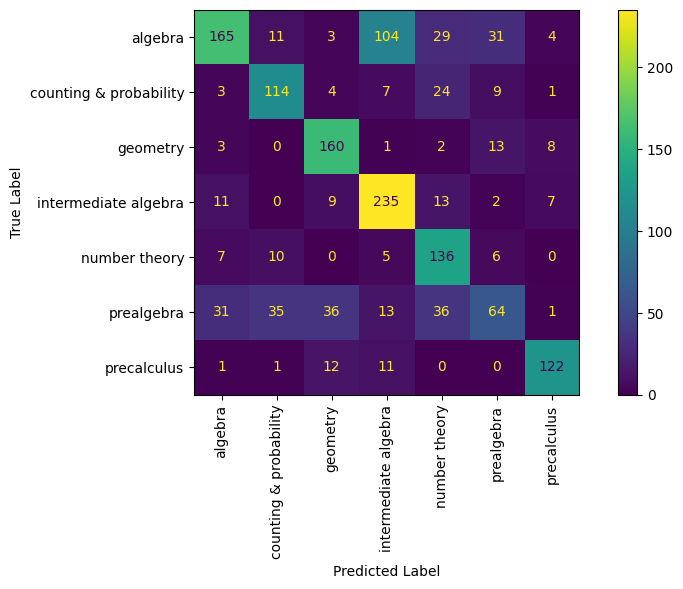

In [376]:
confusion_matrix = metrics.confusion_matrix(label_test, preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [category for category in problems_categorized])

fig, ax = plt.subplots(figsize=(10,5))
cm_display.plot(ax=ax)
plt.xticks(fontsize = 10,rotation = 90)
plt.yticks(fontsize = 10)
plt.ylabel('True Label', fontsize = 10)
plt.xlabel('Predicted Label', fontsize = 10)
plt.show()

In [377]:
# https://stackoverflow.com/questions/40729875/calculate-precision-and-recall-in-a-confusion-matrix
from operator import truediv
import numpy as np

tp = np.diag(confusion_matrix)
prec = list(map(truediv, tp, np.sum(confusion_matrix, axis=0)))
rec = list(map(truediv, tp, np.sum(confusion_matrix, axis=1)))

for category, pNum, rNum in zip(problems_categorized, prec, rec):
    print(f"The {category} category has a precision of {pNum.round(2)} and a recall of {rNum.round(2)}\n")

The algebra category has a precision of 0.75 and a recall of 0.48

The counting & probability category has a precision of 0.67 and a recall of 0.7

The geometry category has a precision of 0.71 and a recall of 0.86

The intermediate algebra category has a precision of 0.62 and a recall of 0.85

The number theory category has a precision of 0.57 and a recall of 0.83

The prealgebra category has a precision of 0.51 and a recall of 0.3

The precalculus category has a precision of 0.85 and a recall of 0.83



The model performed fairly well on the subjects apart from the Algebra and Prealgebra subjects. This isn't terribly surprising because Algebra and Prealgebra as subjects are very similar in nature and likely share a lot of overlap in the words used in the problems.

Here is the code for the best MNB model on the difficulties:

In [380]:
categories = [str(problem.level) for problem in problems]
problem_text = [' '.join(problem.problem.lower().replace(".", "").replace("?", "").replace(",", "").split()) for problem in problems]

cv = CountVectorizer(min_df=10, max_df=0.4) # words must show up in at least 10 and no more than 40% of documents
features = cv.fit_transform(problem_text)
print(features.shape)
vocab = cv.get_feature_names_out()
# print(vocab)

mnb = MultinomialNB()

feat_train, feat_test, label_train, label_test = train_test_split(features, categories, test_size=0.2)

mnb.fit(feat_train, label_train)
preds = mnb.predict(feat_test)

(7500, 1487)


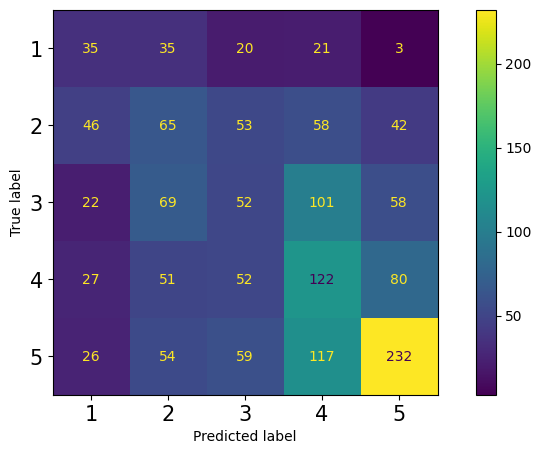

In [381]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [str(level) for level in range(1,6)])

fig, ax = plt.subplots(figsize=(10, 5))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

cm_display.plot(ax=ax)
plt.show()

In [385]:
tp = np.diag(confusion_matrix)
prec = list(map(truediv, tp, np.sum(confusion_matrix, axis=0)))
rec = list(map(truediv, tp, np.sum(confusion_matrix, axis=1)))

for level, pNum, rNum in zip(range(1,6), prec, rec):
    print(f"The {level} level has a precision of {pNum.round(2)} and a recall of {rNum.round(2)}\n")

The 1 level has a precision of 0.22 and a recall of 0.31

The 2 level has a precision of 0.24 and a recall of 0.25

The 3 level has a precision of 0.22 and a recall of 0.17

The 4 level has a precision of 0.29 and a recall of 0.37

The 5 level has a precision of 0.56 and a recall of 0.48



The model performed worse on the difficulties than the subjects. This wasn't very surprising either because the difficulty of a problem is more complicated than simply what words are used in it. Also, it probably isn't the case that certain difficulties share words, in fact it very well may be the case that the more difficult problems use less common words and are thus difficult to categorize.

However we do see that the model performed better on the higher difficulties than the lower difficulties, and overall better than random guessing. Interestingly, difficulty 4 was ofter misclassified as difficulty 3 and 5, but rarely as 1 or 2.

## Conclusions

As we hypothesized, our classifier performed better on the subjects than the difficulties. In the future, it might be interesting to try other kinds of classifiers, as this classifier wasn't able to pick up on any context in the problems. For these math problems especially, we would imagine that context is very important in determining the difficulty of a problem. We are also somewhat limited by the accuracy in these difficulty labels, as they are subjective and not all problems are labeled with a difficulty.

We were impressed with how well the classifier performed nonetheless, and we think that with more data and more advanced models, we could get even better results. 